In [1]:
import os

import scienceplots
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

import torch
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision.transforms import transforms
from torchvision.io import read_image
from torchvision.transforms import ToTensor
from torchvision.io import read_image

import matplotlib.pyplot as plt
from PIL import Image

### HELPERS ###

def get_train_val_test(data, seed):
    """
    Generates train, val and test splits from input dataframe
    """
    train_df, test_df = train_test_split(data, test_size=0.1, random_state=SEED)
    train_df, val_df = train_test_split(train_df, test_size=0.1 / 0.9, random_state=SEED)
    return train_df, val_df, test_df

# Add this path to use SciencePlots (it uses latex)
os.environ["PATH"] += os.pathsep + "/Library/TeX/texbin"

plt.rcParams["figure.figsize"] = (30,30)
plt.style.use(['science', 'notebook'])
pd.set_option('display.max_columns', None)

SEED = 128
BASE_PATH = "../ml-100k"
COLUMN_NAMES = ["user_id", "item_id", "rating", "timestamp"]

# Problem Specific constants
N_USERS = 943
N_ITEMS = 1682

data = pd.read_csv(os.path.join(BASE_PATH, "u.data"),
                   sep="\t", header=None,
                   names=COLUMN_NAMES)
data["user_id"] = data["user_id"] - 1
data["item_id"] = data["item_id"] - 1

assert data["user_id"].min() == 0
assert data["item_id"].min() == 0

assert data["user_id"].max() == N_USERS - 1
assert data["item_id"].max() == N_ITEMS - 1

# 1. Generate train, validation and test

We will generate 80-10-10 splits for train, validation and test. After we have created some useful architectures, we should test the results with multiple experiments (different splits). 

In [64]:
train_df, val_df, test_df = get_train_val_test(data, seed=SEED)

In [65]:
print(f"Train: {train_df.shape[0]}, | Validation: {val_df.shape[0]} | Test: {test_df.shape[0]}")

Train: 80000, | Validation: 10000 | Test: 10000


In [66]:
train_df.to_csv("../data/train_df.csv", header=True, index=False)
val_df.to_csv("../data/val_df.csv", header=True, index=False)
test_df.to_csv("../data/test_df.csv", header=True, index=False)

# 2. Simple Matrix Factorization

In [2]:
class MovielensDataset(Dataset):
    def __init__(self, path, transform=None):
        self.ratings = pd.read_csv(path).values
        self.path = path
        self.transform= transform
        
    def __len__(self):
        return len(self.ratings)
    
    def __getitem__(self, idx):
        """
        Returns uid, iid and rating
        """
        return int(self.ratings[idx][0]), int(self.ratings[idx][1]), float(self.ratings[idx][2])
    
    
class MatrixFactorization(torch.nn.Module):
    def __init__(self, n_users, n_items, n_factors=30):
        super().__init__()
        self.user_factors = torch.nn.Embedding(n_users, n_factors)
        self.user_bias = torch.nn.Embedding(n_users, 1)
            
        self.item_factors = torch.nn.Embedding(n_items, n_factors)
        self.item_bias = torch.nn.Embedding(n_items, 1) 
        
        for param in self.parameters():
            torch.nn.init.normal_(param, std=0.01)  
    
    def forward(self, user, item):
        Q = self.user_factors(user)
        bq = self.user_bias(user).flatten()

        I = self.item_factors(item)
        bi = self.item_bias(item).flatten()

        return (Q*I).sum(-1) + bq + bi

In [3]:
train_dataset = MovielensDataset(path="../data/train_df.csv", transform=ToTensor())
validation_dataset = MovielensDataset(path="../data/val_df.csv", transform=ToTensor())
test_dataset = MovielensDataset(path="../data/test_df.csv", transform=ToTensor())

In [89]:
train_dataloader = DataLoader(train_dataset, batch_size=512, shuffle=True)
validation_dataloader = DataLoader(validation_dataset, batch_size=len(validation_dataset), shuffle=False) # Use all the dataset to compute the MSE
test_dataloader = DataLoader(test_dataset, batch_size=len(test_dataset), shuffle=False) # Use all the dataset to compute the MSE

In [120]:
model = MatrixFactorization(N_USERS, N_ITEMS, n_factors=30)
loss_func = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(),lr=0.002, weight_decay=1e-4)

In [121]:
train_loss = []
val_loss = []
best_val_loss = np.inf

for e in range(40):
    train_losses = []
    val_losses = []
    
    for uid, iid, rating in train_dataloader:
        # Set gradients to zero
        optimizer.zero_grad()
        rating_hat = model(uid.to(torch.long), iid.to(torch.long))
        loss = loss_func(rating_hat, rating.to(torch.float))

        # Backpropagate
        loss.backward()

        # Update the parameters
        optimizer.step()
        train_losses.append(float(loss))
    
    for uid, iid, rating in validation_dataloader:
        rating_hat = model(uid, iid)
        loss = loss_func(rating_hat, rating.to(torch.float))
        val_losses.append(float(loss))
        
    train_loss.append(np.sqrt(np.mean(train_losses)))
    val_loss.append(np.sqrt(np.mean(val_losses)))
    print(f"Epoch {e + 1} | Training loss: {train_loss[-1]} | Validation loss: {val_loss[-1]}")
    
    if val_loss[-1] < best_val_loss:
        torch.save(model.state_dict(), './model_checkpoints/best-model-parameters.pt') # official recommended
        best_val_loss = val_loss[-1]

Epoch 1 | Training loss: 3.2385946331742517 | Validation loss: 2.0714308687018823
Epoch 2 | Training loss: 1.4146050038323636 | Validation loss: 1.0976131878751498
Epoch 3 | Training loss: 1.0431158190109482 | Validation loss: 0.997410969166994
Epoch 4 | Training loss: 0.9832653829843393 | Validation loss: 0.9690518062903222
Epoch 5 | Training loss: 0.9619723370838397 | Validation loss: 0.96163865227667
Epoch 6 | Training loss: 0.9535888512286655 | Validation loss: 0.9552449273796144
Epoch 7 | Training loss: 0.9496543294636057 | Validation loss: 0.9526522355059979
Epoch 8 | Training loss: 0.9457639485819779 | Validation loss: 0.9499596424063367
Epoch 9 | Training loss: 0.9433034163982428 | Validation loss: 0.9512152064673588
Epoch 10 | Training loss: 0.94273984192607 | Validation loss: 0.9487221443097706
Epoch 11 | Training loss: 0.9407356782168291 | Validation loss: 0.946945545350938
Epoch 12 | Training loss: 0.9388265657744257 | Validation loss: 0.9464724336469901
Epoch 13 | Training

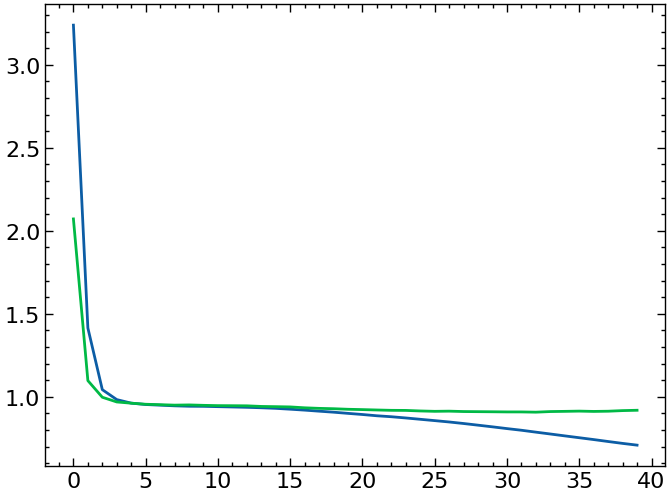

In [122]:
plt.plot(train_loss)
plt.plot(val_loss)

Retrieve best model and generate metrics for test.

In [123]:
model = MatrixFactorization(N_USERS, N_ITEMS, n_factors=30)
model.load_state_dict(torch.load('./model_checkpoints/best-model-parameters.pt'))

<All keys matched successfully>

In [129]:
for uid, iid, rating in test_dataloader:
    rating_hat = model(uid, iid)
    loss = loss_func(rating_hat, rating.to(torch.float))
    print(f"RMSE: {np.sqrt(float(loss))}")

RMSE: 0.9065481221723304


Now, let's try to add some additional information apart from the interaction between users and items.

# 3. MF + poster information

In [14]:
def pil_loader(path: str) -> Image.Image:
    with open(path, "rb") as f:
        img = Image.open(f)
        return img.convert("RGB")

class MovielensPostersDataset(Dataset):
    def __init__(self,
                 ratings_path: str,
                 posters_dir: str,
                 posters_transform=ToTensor()):
        self.ratings_path = ratings_path
        self.ratings = pd.read_csv(ratings_path).values
        self.posters_dir = posters_dir
        self.posters_transform = posters_transform
        
    def __len__(self):
        return len(self.ratings)
    
    def __getitem__(self, idx):
        uid = int(self.ratings[idx][0])
        iid = int(self.ratings[idx][1])
        rating = float(self.ratings[idx][2])
        poster = pil_loader(os.path.join(self.posters_dir, f"{iid + 1}.jpg"))
        
        if self.posters_transform:
            poster = self.posters_transform(poster)
        
        return uid, iid, rating, poster
    
class MatrixFactorizationWithPosterInformation(torch.nn.Module):
    def __init__(self, n_users, n_items, n_factors=30):
        super().__init__()
                
        # User / Item 
        self.user_factors = torch.nn.Embedding(n_users, n_factors)
        self.item_factors = torch.nn.Embedding(n_items, n_factors)
                
        # Biases
        self.user_bias = torch.nn.Embedding(n_users, 1)
        self.item_bias = torch.nn.Embedding(n_items, 1) 
        
        for param in self.parameters():
            torch.nn.init.normal_(param, std=0.01)  
            
        # CNN for feature extraction
        self.model_conv = torchvision.models.resnet18(weights='IMAGENET1K_V1')
        for param in self.model_conv.parameters():
            param.requires_grad = False
        num_ftrs = self.model_conv.fc.in_features
        self.model_conv.fc = torch.nn.Linear(num_ftrs, n_factors)
    
    def forward(self, user, item, poster):
        Q = self.user_factors(user)
        bq = self.user_bias(user).flatten()

        I = self.item_factors(item)
        bi = self.item_bias(item).flatten()
        
        P = self.model_conv(poster)

        return (Q*(I + P)).sum(-1) + bq + bi

In [24]:
datasets = {
    x: MovielensPostersDataset(ratings_path=f"../data/{x}_df.csv",
                               posters_dir="../posters",
                               posters_transform=transforms.Compose([
                                   transforms.Resize((256, 256)),
                                   transforms.ToTensor(),
                                   transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
                               ])
                              )
    for x in ["train", "val", "test"]
}

dataloaders = {x: torch.utils.data.DataLoader(datasets[x], batch_size=1 if x == "train" else 1, shuffle=True) for x in 
               ["train", "val", "test"]}

In [25]:
model = MatrixFactorizationWithPosterInformation(N_USERS, N_ITEMS, n_factors=30)

In [26]:
loss_func = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(),lr=0.002, weight_decay=1e-4)

In [ ]:
train_loss = []
val_loss = []
best_val_loss = np.inf

for e in range(40):
    train_losses = []
    val_losses = []
    
    for uid, iid, rating, poster in dataloaders["train"]:
        # Set gradients to zero
        optimizer.zero_grad()
        rating_hat = model(uid.to(torch.long), iid.to(torch.long), poster)
        loss = loss_func(rating_hat, rating.to(torch.float))

        # Backpropagate
        loss.backward()

        # Update the parameters
        optimizer.step()
        train_losses.append(float(loss))
    
    for uid, iid, rating, poster in dataloaders["test"]:
        ating_hat = model(uid.to(torch.long), iid.to(torch.long), poster)
        loss = loss_func(rating_hat, rating.to(torch.float))
        val_losses.append(float(loss))
        
    train_loss.append(np.sqrt(np.mean(train_losses)))
    val_loss.append(np.sqrt(np.mean(val_losses)))
    print(f"Epoch {e + 1} | Training loss: {train_loss[-1]} | Validation loss: {val_loss[-1]}")
    
    if val_loss[-1] < best_val_loss:
        torch.save(model.state_dict(), './model_checkpoints/best-model-parameters.pt') # official recommended
        best_val_loss = val_loss[-1]